In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE
from joblib import dump
from IPython.display import Image
import os



decision_tree = pd.read_csv('/workspaces/decision-tree-project-omass/diabetes.csv')

df = decision_tree
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [50]:
columns_to_impute = ['Glucose', 'SkinThickness', 'Insulin', 'BMI']
imputer = SimpleImputer(strategy='median')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute].replace(0, np.nan))


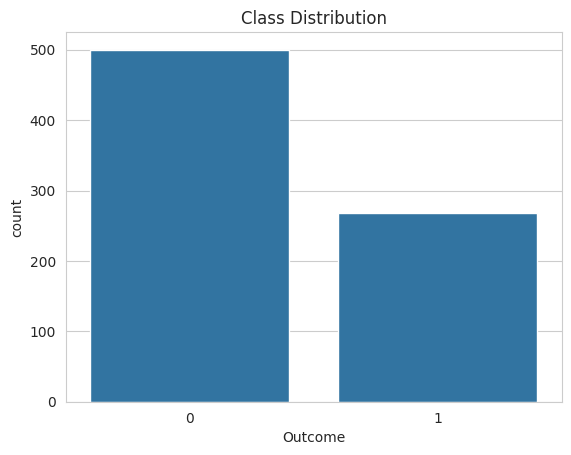

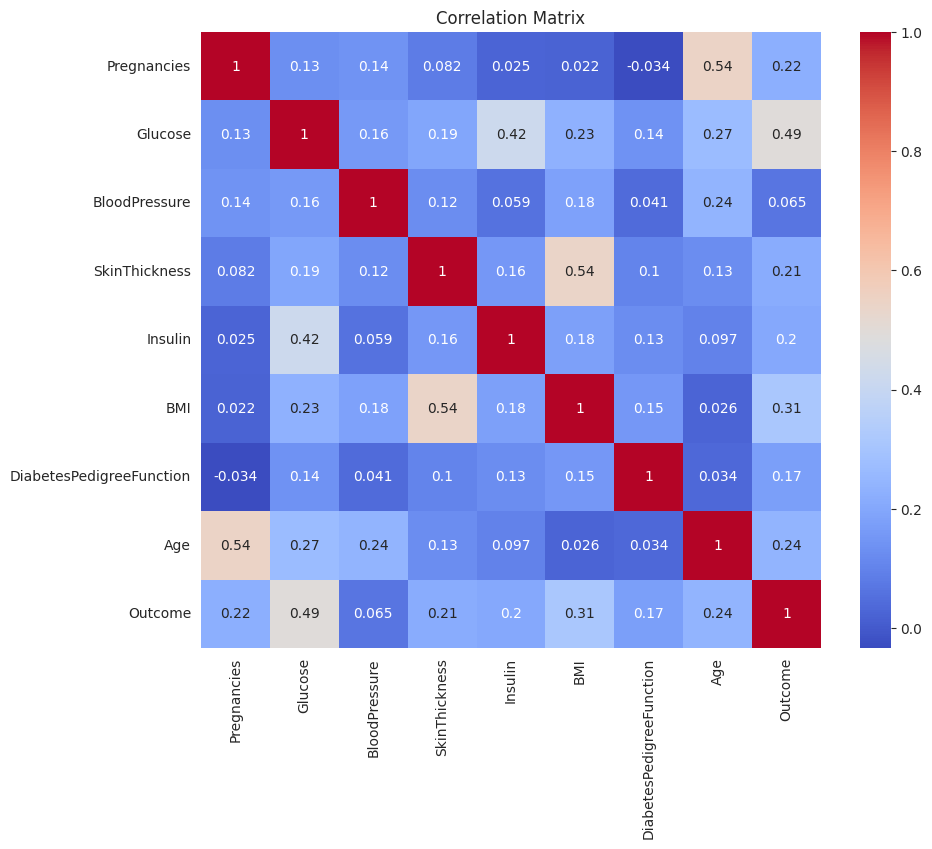

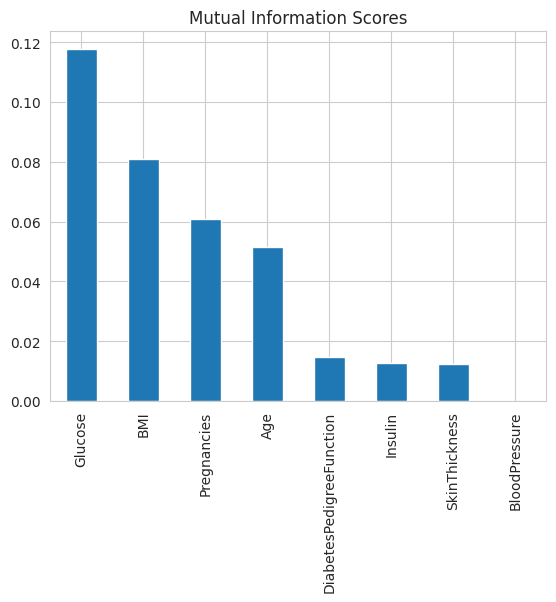

In [51]:
# Visualize class distribution
sns.countplot(x='Outcome', data=df)
plt.title('Class Distribution')
plt.show()

# Generate and visualize correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Calculate mutual information scores
X = df.drop('Outcome', axis=1)
y = df['Outcome']
mutual_info = mutual_info_classif(X, y, random_state=42)
mutual_info_series = pd.Series(mutual_info, index=X.columns)

# Visualize mutual information scores
mutual_info_series.sort_values(ascending=False).plot.bar()
plt.title('Mutual Information Scores')
plt.show()


In [52]:
# Handle class imbalance with SMOTE and split the data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [53]:
# Define parameter grid and perform grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [54]:
# Evaluate the best model from grid search
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}
for metric, value in metrics.items():
    print(f'{metric}: {value}')


Accuracy: 0.78
Precision: 0.7567567567567568
Recall: 0.8316831683168316
F1 Score: 0.7924528301886792


In [59]:
# Save the trained model
dump(best_model, "random_forest_diabetes_model.joblib")


['random_forest_diabetes_model.joblib']